In [1]:
import sys
import time
import datetime as dt
import warnings
import requests
import json
import math
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', 120)

print(f"Pandas version: {pd.__version__}")
print(f"Python version: {'.'.join(list(map(str, sys.version_info[:3])))}")

print(dt.datetime.now().strftime("\n%Y-%m-%d %H:%M:%S"))

Pandas version: 1.1.3
Python version: 3.7.7

2020-12-22 17:34:12


## Подготовка данных для модели

In [2]:
"""
Загружаем подготовленные данные по средней температуре ОЭС Средней Волги (переводим в градусы Цельсия)
"""

temp = pd.read_csv("temp_volga_day.csv", sep=";")
temp["TEMP"] = round((temp["TEMP"] - 32) * 5 / 9, 1)
temp.describe()

,YEAR,MONTH,DAY,TEMP,VISIB
count,2125.000000,2125.000000,2125.000000,2125.000000,2125.000000
mean,2017.477647,6.436235,15.654588,6.062306,28.033714
std,1.683277,3.410727,8.823293,11.256867,55.847506
min,2015.000000,1.000000,1.000000,-26.000000,2.421378
25%,2016.000000,3.000000,8.000000,-2.600000,7.740000
50%,2017.000000,6.000000,16.000000,6.400000,9.549506
75%,2019.000000,9.000000,23.000000,16.100000,11.270370
max,2020.000000,12.000000,31.000000,28.400000,448.533333


In [3]:
"""
Загружаем подготовленные данные по планируемому и фактическому потреблению электроэнергии
"""

gen = pd.read_csv("gen_consum_volga.csv", sep=";")
gen.describe()

,Unnamed: 0,YEAR,MONTH,DAY,E_USE_FACT,E_USE_PLAN,GEN_FACT,GEN_PLAN
count,1854.000000,1854.000000,1854.000000,1854.000000,1854.000000,1854.000000,1854.000000,1854.000000
mean,926.500000,2017.864617,6.586300,15.709817,41581.457751,41709.479339,42374.464237,42448.454925
std,535.348018,1.476021,3.466725,8.793300,4394.955376,4401.777208,4528.160156,4535.835284
min,0.000000,2015.000000,1.000000,1.000000,33321.097222,33549.972222,34190.736111,34345.277778
25%,463.250000,2017.000000,4.000000,8.000000,37612.881944,37697.052083,38287.475694,38331.663194
50%,926.500000,2018.000000,7.000000,16.000000,41320.194444,41479.729167,42106.097222,42202.729167
75%,1389.750000,2019.000000,10.000000,23.000000,45593.013889,45742.520833,46380.000000,46465.187500
max,1853.000000,2020.000000,12.000000,31.000000,50522.569444,50498.486111,51630.180556,51752.736111


In [4]:
"""
Загружаем данные по индексу самоизоляции
"""

izol = pd.read_csv("izol_volga_day.csv", sep=";")
izol_d = {dt.datetime(int(x["YEAR"]), int(x["MONTH"]), int(x["DAY"])):x["INDEX"] for _, x in izol.iterrows()}
izol.describe()

,YEAR,MONTH,DAY,INDEX
count,278.0,278.000000,278.000000,278.000000
mean,2020.0,6.809353,15.856115,1.829871
std,0.0,2.640216,8.812578,0.750170
min,2020.0,2.000000,1.000000,0.830556
25%,2020.0,5.000000,8.000000,1.200309
50%,2020.0,7.000000,16.000000,1.505324
75%,2020.0,9.000000,23.750000,2.518596
max,2020.0,11.000000,31.000000,3.809414


In [5]:
"""
Загружаем данные по индексу потребительских цен (Сбериндекс)
"""

coms = pd.read_csv("sberindex_comsumer.csv", sep=";").groupby("Дата").mean().reset_index()
coms["DATE"] = pd.to_datetime(coms["Дата"], format="%Y-%m-%d")
coms["INDEX"] = coms["Значение"]
coms = coms[["DATE", "INDEX"]]
coms_d = {x["DATE"]:x["INDEX"] for _, x in coms.iterrows()}
coms.describe()

,INDEX
count,362.000000
mean,70.261203
std,12.875730
min,15.222222
25%,63.111111
50%,72.722222
75%,79.638889
max,100.000000


In [6]:
"""
Загружаем данные по индексу активности малого и среднего бизнеса (Сбериндекс)
"""

msp = pd.read_csv("sberindex_msp_activity.csv", sep=";").groupby("DATE").mean().reset_index()
msp["DATE"] = pd.to_datetime(msp["DATE"], format="%Y-%m-%d")
msp_d = {x["DATE"]:x["VALUE"] for _, x in msp.iterrows()}
msp.describe()

,VALUE
count,38.000000
mean,-6.483626
std,11.316611
min,-33.233333
25%,-12.650000
50%,-0.450000
75%,2.230556
max,2.977778


In [7]:
"""
Объединяем данные в один датафрейм для дальнейшей обработки
"""

data = pd.DataFrame(columns=["YEAR", "MONTH", "DAY", "WEEKDAY", "USE_FACT", "TEMP", "VISIB", "II", "COMS", "MSP"])

def get_date(df, loc):
    return dt.datetime(int(df.loc[loc]["YEAR"]), int(df.loc[loc]["MONTH"]), int(df.loc[loc]["DAY"]))

temp_count = 0
date_temp = 0

ii_cur = 2
coms_cur = 70
msp_cur = 0


for k, v in gen.iterrows():
    yy = int(v["YEAR"])
    mm = int(v["MONTH"])
    dd = int(v["DAY"])
    
    date_gen = dt.datetime(yy, mm, dd)
    
    wd = date_gen.weekday()
    use = v["E_USE_FACT"]
    
    
    date_temp = get_date(temp, temp_count)
    while temp_count < len(temp) - 1 and date_temp < date_gen:
        temp_count += 1
        date_temp = get_date(temp, temp_count)
    

    if date_gen in izol_d:
        ii_cur = izol_d[date_gen]
    
    if date_gen in coms_d:
        coms_cur = coms_d[date_gen]

    if date_gen in msp_d:
        msp_cur = msp_d[date_gen]
        
    tt = temp.loc[temp_count]["TEMP"]
    vs = temp.loc[temp_count]["VISIB"]
    
   
    data.loc[k] = [yy, mm, dd, wd, use, tt, vs, ii_cur, coms_cur, msp_cur]
data

,YEAR,MONTH,DAY,WEEKDAY,USE_FACT,TEMP,VISIB,II,COMS,MSP
0,2015.0,11.0,1.0,6.0,42143.708333,-0.6,7.613333,2.000000,70.000000,0.000000
1,2015.0,11.0,2.0,0.0,44020.416667,2.3,6.420000,2.000000,70.000000,0.000000
2,2015.0,11.0,3.0,1.0,43557.458333,5.0,5.366667,2.000000,70.000000,0.000000
3,2015.0,11.0,4.0,2.0,41836.666667,4.2,8.113333,2.000000,70.000000,0.000000
4,2015.0,11.0,5.0,3.0,43676.013889,3.9,6.606667,2.000000,70.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...
1849,2020.0,11.0,23.0,0.0,45955.402778,-7.0,10.424109,1.526080,69.111111,2.922222
1850,2020.0,11.0,24.0,1.0,45784.166667,-7.0,10.424109,1.485802,70.444444,2.922222
1851,2020.0,11.0,25.0,2.0,45824.166667,-7.0,10.424109,1.487809,73.888889,2.922222
1852,2020.0,11.0,26.0,3.0,46075.694444,-7.0,10.424109,1.492593,74.666667,2.922222


In [8]:
"""
Обрезаем данные за последний день - по электроэнергетике не полные данные
"""

data = data[:len(data) - 1]
data

,YEAR,MONTH,DAY,WEEKDAY,USE_FACT,TEMP,VISIB,II,COMS,MSP
0,2015.0,11.0,1.0,6.0,42143.708333,-0.6,7.613333,2.000000,70.000000,0.000000
1,2015.0,11.0,2.0,0.0,44020.416667,2.3,6.420000,2.000000,70.000000,0.000000
2,2015.0,11.0,3.0,1.0,43557.458333,5.0,5.366667,2.000000,70.000000,0.000000
3,2015.0,11.0,4.0,2.0,41836.666667,4.2,8.113333,2.000000,70.000000,0.000000
4,2015.0,11.0,5.0,3.0,43676.013889,3.9,6.606667,2.000000,70.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...
1848,2020.0,11.0,22.0,6.0,44145.444444,-7.0,10.424109,3.080093,59.222222,2.922222
1849,2020.0,11.0,23.0,0.0,45955.402778,-7.0,10.424109,1.526080,69.111111,2.922222
1850,2020.0,11.0,24.0,1.0,45784.166667,-7.0,10.424109,1.485802,70.444444,2.922222
1851,2020.0,11.0,25.0,2.0,45824.166667,-7.0,10.424109,1.487809,73.888889,2.922222


In [9]:
"""
Формируем датафрейм для дальнейшего использования
"""

data_train = pd.DataFrame()
for r, d in data.iterrows():
    data_train.loc[r, "DATE"] = dt.datetime(int(d["YEAR"]), int(d["MONTH"]), int(d["DAY"]))
    data_train.loc[r, "MONTH"] = int(d["MONTH"])
    data_train.loc[r, "DAY"] = int(d["DAY"])
    data_train.loc[r, "WEEKDAY"] = int(d["WEEKDAY"])
    data_train.loc[r, "USE_FACT"] = np.log1p(d["USE_FACT"])
    data_train.loc[r, "TEMP"] = d["TEMP"]
    data_train.loc[r, "VISIB"] = d["VISIB"]
    data_train.loc[r, "II"] = d["II"]
    data_train.loc[r, "COMS"] = d["COMS"]
    data_train.loc[r, "MSP"] = d["MSP"]
data_train

,DATE,MONTH,DAY,WEEKDAY,USE_FACT,TEMP,VISIB,II,COMS,MSP
0,2015-11-01,11.0,1.0,6.0,10.648864,-0.6,7.613333,2.000000,70.000000,0.000000
1,2015-11-02,11.0,2.0,0.0,10.692432,2.3,6.420000,2.000000,70.000000,0.000000
2,2015-11-03,11.0,3.0,1.0,10.681859,5.0,5.366667,2.000000,70.000000,0.000000
3,2015-11-04,11.0,4.0,2.0,10.641552,4.2,8.113333,2.000000,70.000000,0.000000
4,2015-11-05,11.0,5.0,3.0,10.684577,3.9,6.606667,2.000000,70.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...
1848,2020-11-22,11.0,22.0,6.0,10.695268,-7.0,10.424109,3.080093,59.222222,2.922222
1849,2020-11-23,11.0,23.0,0.0,10.735448,-7.0,10.424109,1.526080,69.111111,2.922222
1850,2020-11-24,11.0,24.0,1.0,10.731715,-7.0,10.424109,1.485802,70.444444,2.922222
1851,2020-11-25,11.0,25.0,2.0,10.732589,-7.0,10.424109,1.487809,73.888889,2.922222


In [10]:
"""
Формируем лаговые переменные. 
"""

data_train3m = pd.DataFrame()
for r, d in data_train[30:len(data_train) - 5].iterrows():
    data_train3m.loc[r, "DATE"] = d["DATE"]
    data_train3m.loc[r, "MONTH"] = d["MONTH"]
    data_train3m.loc[r, "DAY"] = d["DAY"]
    data_train3m.loc[r, "WEEKDAY"] = d["WEEKDAY"]
    data_train3m.loc[r, "USE_FACT"] = d["USE_FACT"]
    data_train3m.loc[r, "TEMP"] = d["TEMP"]
    data_train3m.loc[r, "VISIB"] = d["VISIB"]

    data_train3m.loc[r, "USE_FACT1"]  = data_train.loc[r - 1, "USE_FACT"]
    data_train3m.loc[r, "USE_FACT3"]  = data_train.loc[r - 3, "USE_FACT"]
    data_train3m.loc[r, "USE_FACT5"]  = data_train.loc[r - 5, "USE_FACT"]
    data_train3m.loc[r, "USE_FACT7"]  = data_train.loc[r - 7, "USE_FACT"]
    data_train3m.loc[r, "USE_FACT14"] = data_train.loc[r - 14, "USE_FACT"]
    data_train3m.loc[r, "USE_FACT30"] = data_train.loc[r - 30, "USE_FACT"]
    
    data_train3m.loc[r, "TEMP1"] = data_train.loc[r - 1]["TEMP"]
    data_train3m.loc[r, "TEMP3"] = data_train.loc[r - 3]["TEMP"]
    data_train3m.loc[r, "TEMP5"] = data_train.loc[r - 5]["TEMP"]
    data_train3m.loc[r, "TEMP7"] = data_train.loc[r - 7]["TEMP"]
    data_train3m.loc[r, "TEMP14"] = data_train.loc[r - 14]["TEMP"]
    data_train3m.loc[r, "TEMP30"] = data_train.loc[r - 30]["TEMP"]

    data_train3m.loc[r, "II"] = data_train.loc[r]["II"]
    data_train3m.loc[r, "II3"] = data_train.loc[r - 3]["II"]

    data_train3m.loc[r, "COMS"] = data_train.loc[r]["COMS"]
    data_train3m.loc[r, "COMS3"] = data_train.loc[r - 3]["COMS"]

    data_train3m.loc[r, "MSP"] = data_train.loc[r]["MSP"]
        
    data_train3m.loc[r, "USE_PRED1"]  = data_train.loc[r + 1, "USE_FACT"]
    data_train3m.loc[r, "USE_PRED2"]  = data_train.loc[r + 2, "USE_FACT"]
    data_train3m.loc[r, "USE_PRED3"]  = data_train.loc[r + 3, "USE_FACT"]
    data_train3m.loc[r, "USE_PRED4"]  = data_train.loc[r + 4, "USE_FACT"]
    data_train3m.loc[r, "USE_PRED5"]  = data_train.loc[r + 5, "USE_FACT"]
        
data_train3m

,DATE,MONTH,DAY,WEEKDAY,USE_FACT,TEMP,VISIB,USE_FACT1,USE_FACT3,USE_FACT5,USE_FACT7,USE_FACT14,USE_FACT30,TEMP1,TEMP3,TEMP5,TEMP7,TEMP14,TEMP30,II,II3,COMS,COMS3,MSP,USE_PRED1,USE_PRED2,USE_PRED3,USE_PRED4,USE_PRED5
30,2015-12-01,12.0,1.0,1.0,10.735145,0.1,4.740000,10.735573,10.709600,10.739441,10.740813,10.748621,10.648864,-2.2,-5.2,-3.2,-0.6,-2.8,-0.6,2.000000,2.000000,70.000000,70.000000,0.000000,10.736356,10.739927,10.741679,10.703149,10.683180
31,2015-12-02,12.0,2.0,2.0,10.736356,-0.4,6.756667,10.735145,10.692014,10.743705,10.738559,10.752965,10.692432,0.1,-5.5,-6.0,-1.4,-4.4,2.3,2.000000,2.000000,70.000000,70.000000,0.000000,10.739927,10.741679,10.703149,10.683180,10.725968
32,2015-12-03,12.0,3.0,3.0,10.739927,-1.4,7.063333,10.736356,10.735573,10.709600,10.739441,10.758440,10.681859,-0.4,-2.2,-5.2,-3.2,-4.1,5.0,2.000000,2.000000,70.000000,70.000000,0.000000,10.741679,10.703149,10.683180,10.725968,10.727333
33,2015-12-04,12.0,4.0,4.0,10.741679,-1.5,7.700000,10.739927,10.735145,10.692014,10.743705,10.756862,10.641552,-1.4,0.1,-5.5,-6.0,-2.4,4.2,2.000000,2.000000,70.000000,70.000000,0.000000,10.703149,10.683180,10.725968,10.727333,10.732335
34,2015-12-05,12.0,5.0,5.0,10.703149,-1.0,5.286667,10.741679,10.736356,10.735573,10.709600,10.716755,10.684577,-1.5,-0.4,-2.2,-5.2,0.8,3.9,2.000000,2.000000,70.000000,70.000000,0.000000,10.683180,10.725968,10.727333,10.732335,10.736236
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1843,2020-11-17,11.0,17.0,1.0,10.735451,-11.0,10.179250,10.725548,10.679409,10.696048,10.680045,10.656015,10.588794,-10.2,-3.2,-1.1,0.1,2.0,6.7,1.483951,2.468519,70.555556,75.777778,2.922222,10.744567,10.744127,10.743507,10.707751,10.695268
1844,2020-11-18,11.0,18.0,2.0,10.744567,-10.1,10.427937,10.735451,10.674303,10.701942,10.689259,10.629527,10.632100,-11.0,-7.9,-1.0,-0.6,3.1,6.1,1.508951,2.984722,70.666667,63.000000,2.922222,10.744127,10.743507,10.707751,10.695268,10.735448
1845,2020-11-19,11.0,19.0,3.0,10.744127,-6.0,10.460009,10.744567,10.725548,10.679409,10.696048,10.657915,10.638202,-10.1,-10.2,-3.2,-1.1,4.0,3.9,1.539969,1.523457,70.777778,69.666667,2.922222,10.743507,10.707751,10.695268,10.735448,10.731715
1846,2020-11-20,11.0,20.0,4.0,10.743507,-4.9,10.741887,10.744127,10.735451,10.674303,10.701942,10.660746,10.644459,-6.0,-11.0,-7.9,-1.0,4.5,1.6,1.461420,1.483951,80.555556,70.555556,2.922222,10.707751,10.695268,10.735448,10.731715,10.732589


## Создаем baseline - линейная регрессия без лаговых переменных и Сбериндекса

In [11]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [12]:
BACK = 90
test_length = len(data_train3m) - BACK
X_train = data_train3m[:test_length][data_train.columns].drop(columns=["DATE", "II", "COMS", "MSP"])
Y_train = data_train3m[:test_length][["DATE", "USE_PRED1", "USE_PRED2", "USE_PRED3", "USE_PRED4", "USE_PRED5"]]
Y_train = Y_train.set_index(Y_train["DATE"]).drop(columns=["DATE"])
X_train

,MONTH,DAY,WEEKDAY,USE_FACT,TEMP,VISIB
30,12.0,1.0,1.0,10.735145,0.1,4.740000
31,12.0,2.0,2.0,10.736356,-0.4,6.756667
32,12.0,3.0,3.0,10.739927,-1.4,7.063333
33,12.0,4.0,4.0,10.741679,-1.5,7.700000
34,12.0,5.0,5.0,10.703149,-1.0,5.286667
...,...,...,...,...,...,...
1753,8.0,19.0,2.0,10.507459,13.5,10.080247
1754,8.0,20.0,3.0,10.512785,13.4,9.959259
1755,8.0,21.0,4.0,10.511171,14.2,10.204321
1756,8.0,22.0,5.0,10.480391,15.0,9.643210


In [13]:
Y_train.head()

,USE_PRED1,USE_PRED2,USE_PRED3,USE_PRED4,USE_PRED5
DATE,,,,,
2015-12-01,10.736356,10.739927,10.741679,10.703149,10.683180
2015-12-02,10.739927,10.741679,10.703149,10.683180,10.725968
2015-12-03,10.741679,10.703149,10.683180,10.725968,10.727333
2015-12-04,10.703149,10.683180,10.725968,10.727333,10.732335
2015-12-05,10.683180,10.725968,10.727333,10.732335,10.736236


In [14]:
lr = LinearRegression()
lr.fit(X_train.values, Y_train.values)
Y_predict = lr.predict(X_train)
print(lr.coef_)

[[ 4.02052511e-04 -1.54101233e-04  1.14553683e-03  8.83464654e-01
  -1.00303534e-03  1.50884698e-06]
 [ 8.01502783e-04 -2.63686308e-04  2.95973448e-03  7.85449163e-01
  -1.84108247e-03  1.10845216e-05]
 [ 9.04670256e-04 -3.76362789e-04  5.92430506e-03  8.00064318e-01
  -1.70470389e-03  2.47099282e-05]
 [ 9.60592106e-04 -4.92647445e-04  9.20307320e-03  8.39668454e-01
  -1.31028397e-03  1.03738494e-05]
 [ 1.00419691e-03 -5.88003734e-04  1.23630049e-02  8.92060656e-01
  -8.03819057e-04 -3.76288912e-06]]


In [15]:
"""
Показатели качества для базовой модели
"""

def print_metric():
    for day in range(5):
        original = np.expm1(Y_train[Y_train.columns[day]].values)
        predict  = np.expm1(Y_predict[:,day])
        print(f'Predict for {day + 1} days: MAE={mean_absolute_error(original, predict):.2f}, R2={r2_score(original, predict):.2f}, MAPE={mean_absolute_percentage_error(original, predict):.2f}')

print_metric()

Predict for 1 days: MAE=707.35, R2=0.96, MAPE=1.72
Predict for 2 days: MAE=1048.33, R2=0.92, MAPE=2.54
Predict for 3 days: MAE=1049.21, R2=0.92, MAPE=2.54
Predict for 4 days: MAE=959.64, R2=0.92, MAPE=2.32
Predict for 5 days: MAE=827.23, R2=0.94, MAPE=1.99


Проверка на holdout данных

In [16]:
X_train = data_train3m[test_length:][data_train.columns].drop(columns=["DATE", "II", "COMS", "MSP"])
Y_train = data_train3m[test_length:][["DATE", "USE_PRED1", "USE_PRED2", "USE_PRED3", "USE_PRED4", "USE_PRED5"]]
Y_train = Y_train.set_index(Y_train["DATE"]).drop(columns=["DATE"])

Y_predict = lr.predict(X_train)
print_metric()

Predict for 1 days: MAE=573.98, R2=0.92, MAPE=1.44
Predict for 2 days: MAE=819.48, R2=0.87, MAPE=2.05
Predict for 3 days: MAE=822.20, R2=0.88, MAPE=2.05
Predict for 4 days: MAE=685.70, R2=0.91, MAPE=1.69
Predict for 5 days: MAE=625.49, R2=0.93, MAPE=1.53


## Построение сложной модели, учитывающей значения лаговых переменных

In [17]:
BACK = 90
test_length = len(data_train3m) - BACK
X_train = data_train3m[:test_length].drop(columns=["DATE", "USE_PRED1", "USE_PRED2", "USE_PRED3", "USE_PRED4", "USE_PRED5"])
Y_train = data_train3m[:test_length][["DATE", "USE_PRED1", "USE_PRED2", "USE_PRED3", "USE_PRED4", "USE_PRED5"]]
Y_train = Y_train.set_index(Y_train["DATE"]).drop(columns=["DATE"])
X_train

,MONTH,DAY,WEEKDAY,USE_FACT,TEMP,VISIB,USE_FACT1,USE_FACT3,USE_FACT5,USE_FACT7,USE_FACT14,USE_FACT30,TEMP1,TEMP3,TEMP5,TEMP7,TEMP14,TEMP30,II,II3,COMS,COMS3,MSP
30,12.0,1.0,1.0,10.735145,0.1,4.740000,10.735573,10.709600,10.739441,10.740813,10.748621,10.648864,-2.2,-5.2,-3.2,-0.6,-2.8,-0.6,2.000000,2.000000,70.000000,70.000000,0.000000
31,12.0,2.0,2.0,10.736356,-0.4,6.756667,10.735145,10.692014,10.743705,10.738559,10.752965,10.692432,0.1,-5.5,-6.0,-1.4,-4.4,2.3,2.000000,2.000000,70.000000,70.000000,0.000000
32,12.0,3.0,3.0,10.739927,-1.4,7.063333,10.736356,10.735573,10.709600,10.739441,10.758440,10.681859,-0.4,-2.2,-5.2,-3.2,-4.1,5.0,2.000000,2.000000,70.000000,70.000000,0.000000
33,12.0,4.0,4.0,10.741679,-1.5,7.700000,10.739927,10.735145,10.692014,10.743705,10.756862,10.641552,-1.4,0.1,-5.5,-6.0,-2.4,4.2,2.000000,2.000000,70.000000,70.000000,0.000000
34,12.0,5.0,5.0,10.703149,-1.0,5.286667,10.741679,10.736356,10.735573,10.709600,10.716755,10.684577,-1.5,-0.4,-2.2,-5.2,0.8,3.9,2.000000,2.000000,70.000000,70.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1753,8.0,19.0,2.0,10.507459,13.5,10.080247,10.501937,10.454629,10.496888,10.503620,10.495867,10.502818,13.8,14.2,13.1,17.2,21.6,19.5,1.235648,2.584877,78.222222,64.666667,0.566667
1754,8.0,20.0,3.0,10.512785,13.4,9.959259,10.507459,10.499559,10.467054,10.500688,10.513696,10.497947,13.5,14.9,12.9,15.2,23.9,19.6,1.215123,1.393981,80.111111,75.888889,0.566667
1755,8.0,21.0,4.0,10.511171,14.2,10.204321,10.512785,10.501937,10.454629,10.496888,10.518390,10.498659,13.4,13.8,14.2,13.1,22.3,20.3,1.182407,1.213580,86.555556,78.111111,0.566667
1756,8.0,22.0,5.0,10.480391,15.0,9.643210,10.511171,10.507459,10.499559,10.467054,10.481543,10.494756,14.2,13.5,14.9,12.9,18.7,18.4,2.014660,1.235648,71.333333,78.222222,0.566667


In [18]:
Y_train

,USE_PRED1,USE_PRED2,USE_PRED3,USE_PRED4,USE_PRED5
DATE,,,,,
2015-12-01,10.736356,10.739927,10.741679,10.703149,10.683180
2015-12-02,10.739927,10.741679,10.703149,10.683180,10.725968
2015-12-03,10.741679,10.703149,10.683180,10.725968,10.727333
2015-12-04,10.703149,10.683180,10.725968,10.727333,10.732335
2015-12-05,10.683180,10.725968,10.727333,10.732335,10.736236
...,...,...,...,...,...
2020-08-19,10.512785,10.511171,10.480391,10.465983,10.508389
2020-08-20,10.511171,10.480391,10.465983,10.508389,10.513376
2020-08-21,10.480391,10.465983,10.508389,10.513376,10.514514


In [19]:
lr = LinearRegression()
lr.fit(X_train.values, Y_train.values)
Y_predict = lr.predict(X_train)
print(lr.coef_)

[[ 1.02238419e-04 -9.95805702e-05  3.59807204e-03  1.15398528e+00
  -5.66178302e-04 -7.79839503e-06 -3.58049101e-01 -6.05437699e-02
   4.33996904e-01 -2.23014244e-01  1.40165788e-02 -3.27862327e-02
  -1.91906011e-05 -1.16710608e-04  2.58698226e-04 -1.83079916e-05
  -5.81091603e-05 -4.57247613e-05 -6.09747852e-03  5.17079530e-04
  -7.51083210e-04 -5.62974455e-05  6.23427595e-04]
 [ 1.81102167e-05 -2.81125591e-04  1.14255097e-03  7.06382133e-01
  -1.27648292e-03 -8.22732352e-06 -2.57551575e-02 -2.55816895e-02
   7.85991893e-01 -5.15031332e-01  1.09078033e-02 -3.88749516e-02
   1.64715493e-04 -1.44624069e-05  6.98789342e-04 -2.04186013e-04
  -2.04535382e-04  1.07264586e-04 -2.75702568e-03 -1.94496443e-03
  -6.51149176e-04 -2.12246019e-04  8.31441543e-04]
 [-3.14592718e-04 -3.23268958e-04  3.99614587e-03  6.92046776e-01
  -1.58970255e-03  7.39581234e-06 -1.45986352e-01  3.36204668e-01
   4.04056405e-01 -3.73700025e-01  7.76499059e-02 -1.45735073e-01
   2.83714493e-04  1.56510949e-04  6.127

In [20]:
print_metric()

Predict for 1 days: MAE=599.38, R2=0.97, MAPE=1.46
Predict for 2 days: MAE=566.89, R2=0.97, MAPE=1.37
Predict for 3 days: MAE=803.98, R2=0.94, MAPE=1.94
Predict for 4 days: MAE=710.11, R2=0.95, MAPE=1.70
Predict for 5 days: MAE=789.10, R2=0.94, MAPE=1.90



### Валидация сложной модели на неизвестных данных

In [21]:
X_train = data_train3m[test_length:].drop(columns=["DATE", "USE_PRED1", "USE_PRED2", "USE_PRED3", "USE_PRED4", "USE_PRED5"])
Y_train = data_train3m[test_length:][["DATE", "USE_PRED1", "USE_PRED2", "USE_PRED3", "USE_PRED4", "USE_PRED5"]]
Y_train = Y_train.set_index(Y_train["DATE"]).drop(columns=["DATE"])

In [22]:
Y_predict = lr.predict(X_train.values)
print_metric()

Predict for 1 days: MAE=442.49, R2=0.96, MAPE=1.11
Predict for 2 days: MAE=368.55, R2=0.97, MAPE=0.91
Predict for 3 days: MAE=644.26, R2=0.92, MAPE=1.60
Predict for 4 days: MAE=495.41, R2=0.95, MAPE=1.21
Predict for 5 days: MAE=603.74, R2=0.93, MAPE=1.47


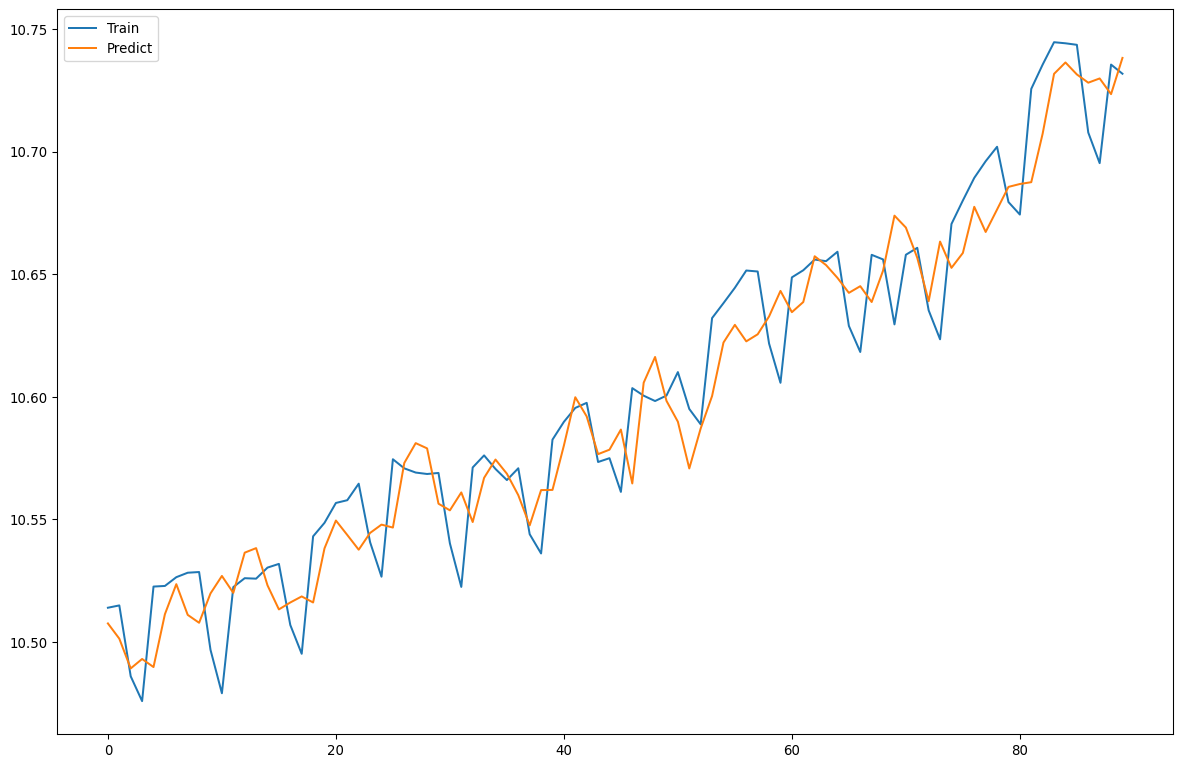

In [23]:
plt.figure(figsize=(15, 10), dpi=96)
plt.plot(np.array(Y_train.reset_index()["USE_PRED3"]),label='Train')
plt.plot(Y_predict[:,2],label='Predict')
plt.legend()
plt.show()

In [26]:
with open('model_data.pkl', 'wb') as handle:
    pickle.dump({'model': lr, 'data':data_train3m.set_index(data_train3m['DATE'])}, handle, protocol=pickle.HIGHEST_PROTOCOL)